In [1]:
import h5py
import numpy as np
import scipy.ndimage
import scipy.optimize
import tensorflow as tf
# import tensorflow_probability as tfp
# from tensorflow import keras

#import time

import matplotlib.pyplot as plt

# Fitting the DM-to-baryon formulas

We define the following variables:
1. $T$ is the temperature. $\rho$ is the ratio of dark matter density to the mean DM density, and $\rho_b$ is the same quantity for baryons.
2. $\rho'$ is the gradient of the density field. For cell $i$ in a skewer, we make the approximation $\rho' \approx c(\rho_{i+1}-\rho_{i-1})$, where $c$ is some constant that is simply absorbed by $v_0$ (see the below formula).
3. $T_0$, $\rho_{b,0}$, and $v_0$ are scaling constants, and the $\gamma$'s are the exponential parameters.
4. $\sigma_T$, $\sigma_\rho$, $\sigma_v$ are the smoothing scales for temperature, baryon density, and baryon velocity, respectively. (These are all on the order of ~1.)

Baryon temperature:
$$T = T_0 [\text{gaussian_smoothing}(\rho, \sigma_T)]^{\gamma_T-1} $$
Baryon density:
$$\rho_b = \rho_{b,0} [\text{gaussian_smoothing}(\rho, \sigma_\rho)]^{\gamma_\rho-1} $$
Baryon velocity:
$$v = v_0 [\text{gaussian_smoothing}(\rho', \sigma_v)]^{\gamma_v-1} $$

## Gaussian filter function
In the (differentiable) optimization process, `gaussian_blur` replaces `scipy.ndimage.gaussian_filter`.

In [2]:
def gaussian_blur(img, kernel_size, sigma):
    def gauss_kernel(channels, kernel_size, sigma):
        ax = tf.range(-kernel_size // 2 + 1.0, kernel_size // 2 + 1.0)
        xx, yy = tf.meshgrid(ax, ax)
        kernel = tf.exp(-(xx ** 2 + yy ** 2) / (2.0 * sigma ** 2))
        kernel = kernel / tf.reduce_sum(kernel)
        kernel = tf.tile(kernel[..., tf.newaxis], [1, 1, channels])
        return kernel

    img = tf.reshape(img, [1, img.shape[-2], img.shape[-1], 1]) # e.g. (1, 1024, 1024, 1)
    
    gaussian_kernel = gauss_kernel(tf.shape(img)[-1], kernel_size, sigma)
    gaussian_kernel = gaussian_kernel[..., tf.newaxis]
    gaussian_kernel = tf.cast(gaussian_kernel, 'float64')

    result = tf.nn.depthwise_conv2d(img, gaussian_kernel, [1, 1, 1, 1],
                                  padding='SAME', data_format='NHWC')
    return result

## Load in data

In [3]:
filename = "../../../../../cscratch1/sd/jupiter/sim2_z3_FGPA_cgs.h5"
tf_filename = "../lya_fields/results/tf_fields1x1x1024.h5"

h5 = h5py.File(filename,'r')
tf_h5 = h5py.File(tf_filename,'r')

# full fields
DM_dens = h5['native_fields']['matter_density'][()] # rho
baryon_dens = h5['native_fields']['baryon_density'][()] # rho_b
temperature = h5['native_fields']['temperature'][()] # T
baryon_vel = h5['native_fields']['velocity_z'][()] # v

# treal = tf_h5['tau_real'][()] # real-space optical depth (lya-tf)
# treal_g = h5['derived_fields']['tau_real'][()] # real-space optical depth (Gimlet)
# tred = tf_h5['tau_red'][()] # redshift-space optical depth (lya-tf)

h5.close()
tf_h5.close()

In [4]:
# train on one part of the snapshot
train_inds = (512,
              slice(0, 1024),
              slice(0, 1024))
rho_train = DM_dens[train_inds]
rhob_train = baryon_dens[train_inds]
temp_train = temperature[train_inds]
vel_train = baryon_vel[train_inds]

# test on one skewer
test_inds = (0, 0, slice(0, 1024))
rho_test = DM_dens[test_inds]
rhob_test = baryon_dens[test_inds]
temp_test = temperature[test_inds]
vel_test = baryon_vel[test_inds]

rho_train = tf.cast(rho_train, 'float64')

In [5]:
def bary_model(rho, x0, sigma, gamma):
    '''
    The model for fitting x = x0 * [gaussian_smoothing(rho_DM, sigma)]^(gamma-1),
    where x is the baryon property.
    
    '''
    
    return x0 * (scipy.ndimage.gaussian_filter(rho, sigma))**(gamma - 1)

def bary_model_diff(rho, x0, sigma, gamma):
    '''
    The (differentiable) model for fitting x = x0 * [gaussian_smoothing(rho_DM, sigma)]^(gamma-1),
    where x is the baryon property.
    
    '''
    
    result = x0 * (gaussian_blur(rho, sigma*2, sigma))**(gamma - 1)
    return tf.squeeze(result)

def obj_fn(params, x):
    '''
    The objective function to be minimized for fitting. 
    
    PARAMETERS
    ----------
    params: (x0, sigma, gamma)
    x: the baryon property to fit; can be 'rho' (baryon density),
    't' (temperature), or 'v' (velocity)
    
    '''
    
    x0, sigma, gamma = params
    
    x_pred = bary_model_diff(rho_train, x0, sigma, gamma)
    
    if x == 'rho':
        return np.mean(np.square(rhob_train - x_pred))
    elif x == 't':
        return np.mean(np.square(temp_train - x_pred))
    elif x == 'v':
        return np.mean(np.square(vel_train - x_pred))
    else:
        raise ValueError("Invalid argument: x must be 'rho', 't', or 'v'")
        
def obj_fn_logT(params):
    '''
    The objective function to be minimized for fitting log(T). When using scipy.optimize.minimize,
    fitting log(T_0) may yield better results than fitting T_0, but it's much slower (on the order
    of tens of minutes for 10 iterations).
    
    PARAMETERS
    ----------
    params: (logT0, sigma, gamma)
    
    '''
    
    logT0, sigma, gamma = params
    
    logT_pred = logT0 + (gamma - 1)*np.log10(gaussian_blur(rho_train, sigma*2, sigma))
    
    return np.mean(np.square(temp_train - 10**logT_pred))

## Testing gaussian filters

In [ ]:
x0 = 3
sigma = 1.5
gamma = 1.6

# using ndimage.gaussian_filter, sigma = 1.5
plt.figure(figsize=(3,3))
plt.imshow(np.log10(bary_model(rho_train, x0, sigma, gamma)))
plt.title("gaussian_filter")
plt.colorbar()
plt.show()

plt.figure(figsize=(3,3))
plt.imshow(np.log10(bary_model_diff(rho_train, x0, sigma, gamma)))
plt.title("gaussian_blur, kernel = 2 * sigma")
plt.colorbar()
plt.show()

result = x0 * (gaussian_blur(rho_train, sigma*5, sigma))**(gamma - 1)
plt.figure(figsize=(3,3))
plt.imshow(np.log10(result[0,...,0]))
plt.title("gaussian_blur, kernel = 5 * sigma")
plt.colorbar()
plt.show()

## Using scipy.optimize.minimize

This works with gaussian_blur, which is differentiable, but not gaussian_filter.

### Optimizing for $\rho_b$'s 3 parameters

In [90]:
# initial guess
guess = (np.mean(rhob_train), 1, 1.6) # np.mean(rhob_train) ~ 0.8
print(guess)

(0.7772019, 1, 1.6)

In [91]:
guess = (1.51538566, 3.8727029, 1.81753521) # after ~50 iterations

options = {'maxiter': 100, 'disp': True}
result = scipy.optimize.minimize(obj_fn, guess, args=('rho'), options = options)

Optimization terminated successfully.
         Current function value: 1.143215
         Iterations: 14
         Function evaluations: 76
         Gradient evaluations: 19


In [88]:
# previous value of objective function
obj_fn(guess, 'rho')

15.82663167315113

In [92]:
result

      fun: 1.143214990188187
 hess_inv: array([[ 3.91936367e-01, -2.69964119e-01, -5.44534764e-02],
       [-2.69964119e-01,  1.47710389e+01,  8.42450277e-02],
       [-5.44534764e-02,  8.42450277e-02,  8.38617752e-03]])
      jac: array([-3.42726707e-07,  4.47034836e-08, -2.38418579e-06])
  message: 'Optimization terminated successfully.'
     nfev: 76
      nit: 14
     njev: 19
   status: 0
  success: True
        x: array([1.15997566, 3.3063766 , 1.89804891])

### Optimizing for $T$

In [113]:
guess = (10000, 1, 1.6) # initial guess

In [130]:
#guess = (1.26209647e+04, 1.00005124e+00, 1.41253306e+00) # after 9 iterations
guess = (1.23905759e+04, 4.00677777e+00, 1.45035417e+00) # after 7 more

options = {'maxiter': 100, 'disp': True}
result = scipy.optimize.minimize(obj_fn, guess, args=('t'), options = options)

         Current function value: 2591739.344650
         Iterations: 1
         Function evaluations: 333
         Gradient evaluations: 81


In [126]:
# previous value of objective function
obj_fn(guess, 't')

2666814.3737380845

In [131]:
result

      fun: 2591739.344649665
 hess_inv: array([[ 1.00000000e+00,  1.89709833e-07, -1.28199423e-05],
       [ 1.89709833e-07,  1.00031348e+00,  4.58965484e-04],
       [-1.28199423e-05,  4.58965484e-04,  2.11727328e-07]])
      jac: array([ 1.16781250e+02,  2.18061812e+05, -8.40696531e+05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 333
      nit: 1
     njev: 81
   status: 2
  success: False
        x: array([1.23905759e+04, 4.00657396e+00, 1.46157072e+00])

### adjusting x0 and sigma

https://stackoverflow.com/questions/61107875/how-to-pass-meshgrid-as-an-argument-to-a-function-which-only-allows-an-array-in

### Optimizing for $v$

In [ ]:
## testing np.roll
# x1 = np.array([[[1, 2, 3]]])
# print(x1.shape)
# print(np.roll(x1, -1, axis=-1)) # 2, 3, 1
# # (2,3,1) - (3,1,2) = (-1,2,-1)
# print(np.roll(x1, -1, axis=-1) - np.roll(x1, 1, axis=-1))

In [6]:
rho_grad = np.roll(rho_train, -1, axis=-1) - \
        np.roll(rho_train, 1, axis=-1)

In [22]:
print("mean of rho': " + str(np.mean(rho_grad)))
print("std of rho': " + str(np.std(rho_grad)))
print("mean of v: " + str(np.mean(baryon_vel)))
print("std of v: " + str(np.std(baryon_vel)))

mean of rho': 0.0
std of rho': 11.561242410993842
mean of v: -28386.48
std of v: 8145820.5


In [21]:
guess = (1e7, 1, 1.8) # initial guess

In [22]:
#guess = (5.45670809e+05, 1.00005053e+00, 1.6) # after 9 iterations

options = {'maxiter': 100, 'disp': True}
result = scipy.optimize.minimize(obj_fn, guess, args=('v'), options = options)

/global/homes/j/jupiter/.conda/envs/lya-tf/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/global/homes/j/jupiter/.conda/envs/lya-tf/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/global/homes/j/jupiter/.conda/envs/lya-tf/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/global/homes/j/jupiter/.conda/envs/lya-tf/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/global/homes/j/jupiter/.conda/envs/lya-tf/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


         Current function value: 45937734406951.367188
         Iterations: 16
         Function evaluations: 192
         Gradient evaluations: 43


In [30]:
# previous value of objective function
obj_fn(guess, 'v')

1.2910083290623558e+16

In [23]:
result

      fun: 45937734406951.37
 hess_inv: array([[ 1.76137207e-01, -5.31260048e-17,  5.03473937e-09],
       [-5.31260048e-17,  1.07629465e-26,  3.07345584e-23],
       [ 5.03473937e-09,  3.07345584e-23,  2.80755626e-16]])
      jac: array([ 1.57286400e+06,  1.10100480e+07, -5.55488064e+12])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 192
      nit: 16
     njev: 43
   status: 2
  success: False
        x: array([1.46103156e+06, 1.00005113e+00, 1.00007690e+00])

In [52]:
n = 11
x0 = np.linspace(2.5, 3.5, n)
sigma = np.linspace(1, 2, n)
losses = np.ndarray((n,n))

#X0, Sigma = np.meshgrid(x0, sigma)#, sparse=True)

#result = map(lambda params: obj_fn_vec(params[0], params[1]), \
             #zip(X0.flatten(), Sigma.flatten()))
    
# losses = np.fromiter(result, dtype=np.float)
# losses = np.reshape(losses, (n,n))

In [53]:
start = time.time()

for i in range(n):
    for j in range(n):
        params = (x0[i], sigma[j], 1.6, 'rho')
        losses[i,j] = obj_fn(params)
        
print('Duration:', np.round(time.time() - start, 3))

plt.imshow(losses)
plt.colorbar()
plt.show()

Duration: 13.456


In [62]:
from numpy import unravel_index

min_index = np.argmin(losses)
min_ind = unravel_index(min_index, losses.shape)

best_rho0 = x0[min_ind[0]]
best_sigma_rho = sigma[min_ind[1]]

print('Minimum loss:', losses[min_ind])
print('\nBest values:')
print('rho0 = ' + str(best_rho0))
print('sigma_rho = ' + str(best_sigma_rho))

Minimum loss: 8.796258926391602

Best values:
x0 = 3.2
sigma = 1.4


Do the same for temperature.

In [122]:
for i in range(1, 6):
    params = (10000, i, 1.6, 't')
    print(obj_fn(params))

28114178.0
15023663.0
11571787.0
11959381.0
13681554.0


In [98]:
print('mean(T):', np.mean(temp_train))

mean(T): 8722.626


Duration: 14.395


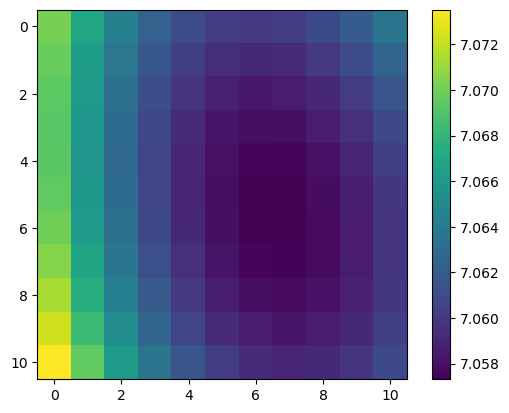

In [138]:
n = 11
log10_t0 = np.linspace(3.98, 4.001, n)
t0 = 10**log10_t0
sigma_t = np.linspace(2.8, 3.5, n)

losses = np.ndarray((n,n))

start = time.time()

for i in range(n):
    for j in range(n):
        #print('hi')
        params = (t0[i], sigma_t[j], 1.6, 't')
        losses[i,j] = obj_fn(params)
        
print('Duration:', np.round(time.time() - start, 3))

plt.imshow(np.log10(losses))
plt.colorbar()
plt.show()

In [141]:
min_ind

(6, 7)

In [140]:
min_index = np.argmin(losses)
min_ind = unravel_index(min_index, losses.shape)

best_t0 = t0[min_ind[0]]
best_sigma_t = sigma_t[min_ind[1]]

print('Minimum loss:', losses[min_ind])
print('\nBest values:')
print('T_0 = ' + str(best_t0))
print('sigma_T = ' + str(best_sigma_t))

Minimum loss: 11410698.0

Best values:
T_0 = 9831.0521528177
sigma_T = 3.29


### adjusting gamma

In [ ]:
gammas = np.linspace(1.7, 1.71, 10)
losses = np.empty_like(gammas)

for i in range(len(gammas)):
    losses[i] = obj_fn((3.2, 1.4, gammas[i], 'rho'))
    
plt.plot(losses)
plt.show()

In [4]:
import eos
import grid
import snapshot

from spectrum import gmlt_spec_od_grid

In [ ]:
## define the model; parameters taken from attempt 1
rho_0, sigma_rho, gamma_rho = 1.15997566, 3.3063766, 1.89804891
T_0, sigma_T, gamma_T = 1.23905759e+04, 4.00657396e+00, 1.46157072e+00

def model(rho_pred):
    # get rho and T skewers from analytical formulas
    rhob = rho_0 * (gaussian_blur(rho_pred, sigma_rho*2, sigma_rho))**(gamma_rho - 1)
    temp = T_0 * (gaussian_blur(rho_pred, sigma_T*2, sigma_T))**(gamma_T - 1)
    rhob = tf.squeeze(rhob, axis=-1) # remove the last dimension
    temp = tf.squeeze(temp, axis=-1)
        
    # get the n_hi grid via eos object
    log10_rhob = tf.math.log(rhob) / np.log(10)
    log10_temp = tf.math.log(temp) / np.log(10)
    nhi_field = eos_obj.compute_nhi(log10_rhob, log10_temp)
    nhi = grid.Grid(nhi_field, shape, size)
    
    # get real-space optical depth
    vpara = np.zeros(shape)
    treal_pred = gmlt_spec_od_grid(snap.universe, snap.z, nhi.size,
                nhi.field, temp, vpara, shape[2])
        
    return treal_pred.field

In [5]:
## take a few skewers
shape = [1, 2, 1024]
size = [21.09375 / 1024 * x for x in shape]
inds = (slice(0, shape[0]), slice(0, shape[1]), slice(0, shape[2]))
rho_true = DM_dens[inds]

## new workflow: instead of using treal_true from the simulation, we use
# model(true delta_m) (ie FGPA) as treal_true 
#treal_true = treal[inds]
treal_true = model(rho_true)

# expand dimensions if shape is (1024,)
# rho_true = rho_true[None, None, :]
# treal_true = treal_true[None, None, :]

## load in snapshot properties
filename = "../../../../../cscratch1/sd/jupiter/sim2_z3_FGPA_cgs.h5"
snap = snapshot.Snapshot(filename)

a = snap.scale_factor
z = snap.z
u = snap.universe
h = u.h
omega_b = u.omega_b

## define eos object
rho_crit_100_cgs = 1.8788200386793017e-29
mean_rhob_cgs = omega_b * h*h * rho_crit_100_cgs
a3_inv = 1.0 / (a * a * a)
rhob_cgs_conversion = mean_rhob_cgs * a3_inv

eos_obj = eos.EOS_at_z(z, rhob_cgs_conversion)

In [6]:
rho_true.shape

(1, 2, 1024)

In [7]:
## create starting point for optimization (random noise)
tf.random.set_seed(5)
log10_noise = tf.random.normal(shape, 0, 0.5, tf.float64, seed=1)
rho_pred = tf.Variable(10**log10_noise)

In [66]:
# check that the model works
treal = model(rho_pred)
print(treal.shape)

(1, 2, 1024)


**From the docs for tfp.optimizer.lbfgs_minimize:**

The input to loss_and_grads should have "shape [..., n], where n is the size of the domain of input points, and all others are batching dimensions. The first component of the return value [of loss_and_grads] is a real Tensor of matching shape [...]. The second component (the gradient) is also of shape [..., n] like the input value to the function."

In [22]:
# loss function
#mse = keras.losses.MeanSquaredError() # this sums all losses
#mse = keras.metrics.mean_squared_error() # this has the same shape as the inputs

# x is the predicted rho with shape [x,y,z,1]
# loss_fn = lambda x: \
#     keras.metrics.mean_squared_error(model(x[...,0])[...,None], treal_true[...,None])
loss_fn = lambda x: \
    keras.metrics.mean_squared_error(model(x[...,0])[...,None], treal_true[...,None])

# compute both loss_fn and its gradients wrt x
loss_and_grads = lambda x: tfp.math.value_and_gradient(loss_fn, x)

In [24]:
#loss_fn(rho_pred[...,None])
#loss_fn(np.zeros([1,2,1024,1]))

In [25]:
# the returned values have the correct shapes
# print('output of loss_fn:\n')
# print(loss_fn(rho_pred[...,None]))
# print('\noutput of loss_and_grads:\n')
# print(loss_and_grads(rho_pred[...,None]))

[LBFGS not working with tensorflow 2.0](https://github.com/tensorflow/probability/issues/398)

In [28]:
# optimizer
#optim = tf.optimizers.Adam(learning_rate=0.1)
start = rho_pred[...,None]
optim = tfp.optimizer.lbfgs_minimize(loss_and_grads, \
                                     initial_position=start)

# print('Initial loss:', loss_fn(rho_pred).numpy())

# losses = tfp.math.minimize(loss_fn,
#                            num_steps=3,
#                            optimizer=optim)

# print('Final loss:', losses[-1].numpy())
# treal_pred_final = model(rho_pred) # final prediction for tau_real

InvalidArgumentError: Inputs to operation Select of type Select must have the same size and shape.  Input 0: [1,2,1024] != input 1: [1,2,1024,1] [Op:Select]

In [ ]:
# TODO: replicate results with Gimlet's tau_real
# ...

In [ ]:
# true and predicted log(input)
plt.figure(figsize=(10,4))

plt.plot(np.log10(rho_true), color='black', label='log10(rho) (true)')
plt.plot(np.log10(rho_pred), 'blue', label = 'log10(rho) (pred)', alpha=0.5)
plt.title('log10(rho)')
plt.ylim(-5, 3)
plt.legend()
plt.show()

# true and predicted "data"
plt.figure(figsize=(10,4))
plt.plot(treal_true, color='black', label='tau_real (true)')
plt.plot(treal_pred_final, 'blue', label = 'tau_real (pred)', alpha=0.5)
plt.title('tau_real')
plt.legend()
plt.show()

# loss
plt.figure(figsize=(10,4))
plt.plot(np.log10(losses))
plt.title('log10(loss)')
plt.show()